In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from numpy import linalg as LA

In [29]:
cics_df = pd.read_csv("datasets/cics_KPI_24hrs.csv")

In [ ]:
cics_df.info

In [30]:
cics_df.shape

(288, 10)

In [31]:
cics_df.columns

Index(['SUMMTYPE', 'SCNAME', 'TRANID', 'ENDSTAMP', 'TOTALTRANS', 'MSRESPTIME',
       'AVCPUTIME', 'ABTRANS', 'DB2WAIT', 'RDSPWAIT'],
      dtype='object')

In [32]:
cics_df.head(10)
#drop SUMMTYPE, TRANID, SCNAME, ABTRANS
cics_df = cics_df.drop(["SUMMTYPE", "TRANID", "SCNAME", "ABTRANS"], axis=1)
cics_df = cics_df.dropna()

In [33]:
cics_df.head()

,ENDSTAMP,TOTALTRANS,MSRESPTIME,AVCPUTIME,DB2WAIT,RDSPWAIT
0,Sep 23 2019 4:10:00 PM,98.0,0.067,0.034,56.0,11.0
1,Sep 23 2019 4:15:00 PM,76.0,0.039,0.026,58.0,2.0
2,Sep 23 2019 4:20:00 PM,46.0,0.039,0.027,57.0,4.0
3,Sep 23 2019 4:25:00 PM,104.0,0.034,0.022,64.0,4.0
4,Sep 23 2019 4:30:00 PM,15.0,0.032,0.023,61.0,6.0


In [34]:
#it seems no outlier here
cics_df.describe(include='all')

,ENDSTAMP,TOTALTRANS,MSRESPTIME,AVCPUTIME,DB2WAIT,RDSPWAIT
count,199,199.000000,199.000000,199.000000,199.000000,199.000000
unique,199,NaN,NaN,NaN,NaN,NaN
top,Sep 24 2019 10:30:00 AM,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,75.582915,0.035980,0.021226,66.341709,5.251256
std,NaN,46.701307,0.047956,0.002031,5.977552,6.682344
min,NaN,12.000000,0.027000,0.019000,2.000000,2.000000
25%,NaN,45.500000,0.031000,0.020000,66.000000,4.000000
50%,NaN,74.000000,0.032000,0.021000,67.000000,5.000000
75%,NaN,104.000000,0.032000,0.022000,69.000000,5.000000


In [35]:
cics_df['ENDSTAMP']=pd.to_datetime(cics_df['ENDSTAMP'])

In [49]:
cics_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199 entries, 0 to 287
Data columns (total 6 columns):
ENDSTAMP      199 non-null datetime64[ns]
TOTALTRANS    199 non-null float64
MSRESPTIME    199 non-null float64
AVCPUTIME     199 non-null float64
DB2WAIT       199 non-null float64
RDSPWAIT      199 non-null float64
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.9 KB


Text(0.5, 1.0, 'Time series of CICS reponse time')

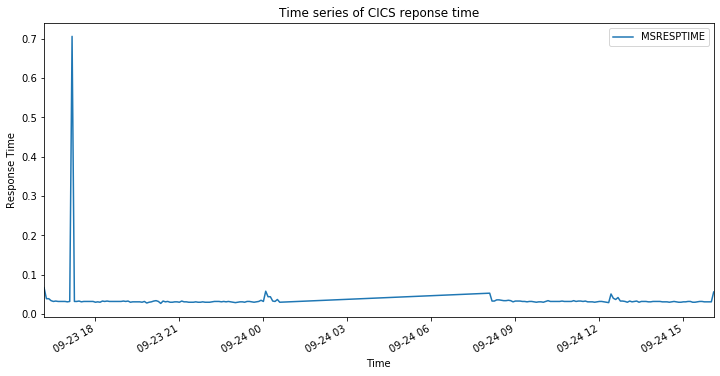

In [36]:
cics_df.plot(x='ENDSTAMP', y='MSRESPTIME', figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Response Time')
plt.title('Time series of CICS reponse time')

In [38]:
#since this is unsupervised learning, I will try to use k-clustering
data = cics_df[["TOTALTRANS","MSRESPTIME","AVCPUTIME","DB2WAIT","RDSPWAIT"]]
data = StandardScaler().fit_transform(data)

n_clusters = range(1,20)
kmeans=[]
scores = []

for i in n_clusters:
    kmean=KMeans(n_clusters=i).fit(data)
    kmeans.append(kmean)

for i in range(len(kmeans)):
    score = kmeans[i].score(data) 
    scores.append(score)

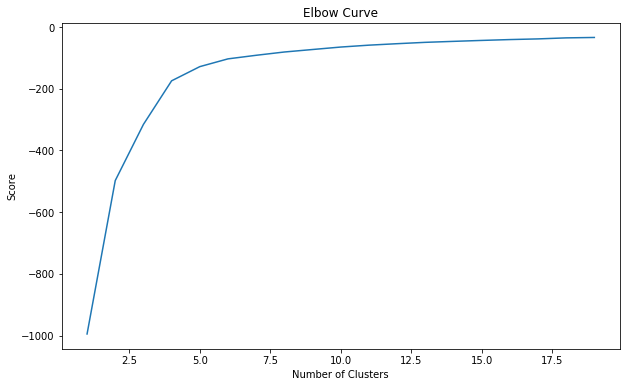

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [13]:
#From the above elbow curve, we see that the graph levels off after 
#7 clusters, implying that addition of more clusters do not 
#explain much more of the variance in our relevant variable; 
#in this case price_usd.

In [14]:
#The underline assumption in the clustering based anomaly detection is that
#if we cluster the data, normal data will belong to clusters while anomalies
#will not belong to any clusters or belong to small clusters. We use the
#following steps to find and visualize anomalies.

In [43]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.05

In [44]:
kmeans[7].cluster_centers_[kmeans[7].labels_[1]-1]

array([ 0.58505926, -0.09875807, -0.58224267,  0.51994037, -0.07607347])

In [45]:
kmeans[7].cluster_centers_

array([[-1.05929642e+00, -7.71491844e-02,  5.37839631e-01,
        -4.45700903e-01, -8.11232877e-02],
       [-6.99447049e-01,  1.40069214e+01, -6.05200128e-01,
        -1.07910363e+01,  1.34646008e+01],
       [ 5.85059264e-01, -9.87580743e-02, -5.82242670e-01,
         5.19940374e-01, -7.60734695e-02],
       [-2.59380079e-01,  3.00932824e-01,  4.08386070e+00,
        -2.17470481e+00, -1.87720359e-01],
       [ 3.90873391e+00, -1.04105923e-01, -1.09878548e+00,
         7.81262939e-01,  1.23136514e-02],
       [ 1.64859902e+00, -5.53270629e-02, -3.70159485e-01,
         3.10065108e-01,  1.83771375e-01],
       [ 6.73905174e-02, -7.50708871e-02, -1.39036186e-01,
         5.45001834e-02, -5.43643521e-02],
       [-6.30666049e-01, -1.03252648e-01, -2.32492823e-01,
         2.43892047e-01, -1.54041163e-01]])

In [18]:
kmeans[7].labels_

array([2, 6, 6, 0, 3, 3, 3, 0, 3, 0, 3, 4, 1, 0, 5, 3, 3, 5, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 5, 0, 0, 5, 0, 5, 3, 4, 0, 0, 0, 3, 4, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 0, 3, 5, 0, 3, 5, 3, 5, 5, 3, 5, 5, 5, 0, 5, 0, 5,
       0, 5, 0, 0, 5, 0, 4, 5, 0, 5, 0, 5, 4, 5, 5, 5, 7, 5, 5, 5, 5, 7,
       5, 5, 5, 5, 7, 4, 4, 6, 4, 4, 0, 0, 3, 0, 6, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 0, 0, 0, 0, 3, 3, 0, 0, 5, 3, 0, 0, 3, 3, 5, 4, 4, 4, 4,
       4, 0, 4, 3, 0, 5, 4, 5, 5, 4, 4, 5, 5, 5, 0, 5, 0, 0, 5, 4, 0, 5,
       2, 6, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5, 3, 0, 0, 0, 0, 3, 4, 0,
       0, 5, 5, 0, 5, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       2], dtype=int32)

In [19]:
distance = getDistanceByPoint(data, kmeans[7])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()

/Users/kyu.kim@ibm.com/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [46]:
distance.shape

(199,)

In [47]:
number_of_outliers

9

In [21]:
threshold

6.179739497683637

In [22]:
#create new column called 'anomaly1', if ano, 1, if not 0
anomaly1 = (distance >= threshold).astype(int)
anomaly1 = anomaly1.to_list()
cics_df['anomaly1'] = anomaly1

In [23]:
cics_df.anomaly1.value_counts()

0    190
1      9
Name: anomaly1, dtype: int64

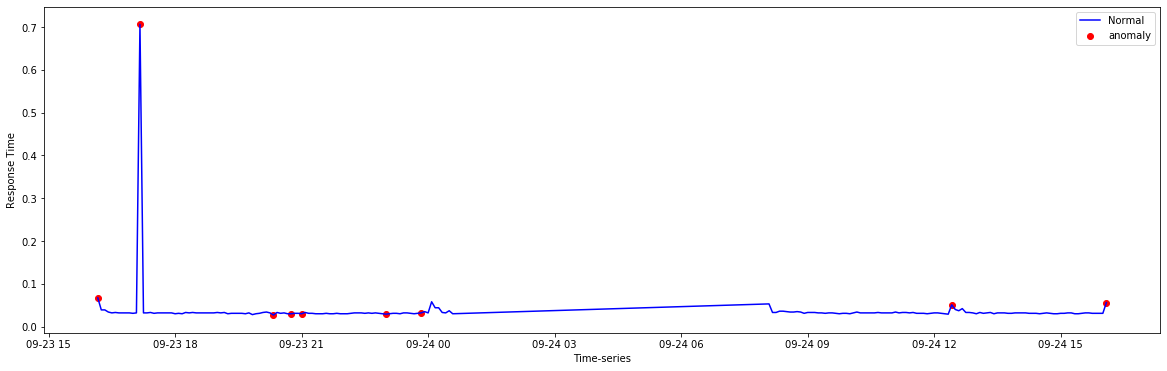

In [24]:
#looks like Kclustering doesn't work. Maybe there are not enough data points
fig, ax = plt.subplots(figsize=(20,6))
a = cics_df.loc[cics_df['anomaly1'] == 1, ['ENDSTAMP', 'MSRESPTIME']] #anomaly

ax.plot(cics_df['ENDSTAMP'], cics_df['MSRESPTIME'], color='blue', label='Normal')
ax.scatter(a['ENDSTAMP'], a['MSRESPTIME'], color='red', label='anomaly')

plt.xlabel('Time-series')
plt.ylabel('Response Time')
plt.legend()
plt.show() 

In [25]:
#SVM
from sklearn.svm import OneClassSVM

# train oneclassSVM 
# need to define hyperparameter kernel(good to capture non linear data points) 
# gamma (how each each datasample influence the model) higher gamma, lower SD
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)
model.fit(data)
cics_df['anomaly3']=pd.Series(model.predict(data)).to_list()


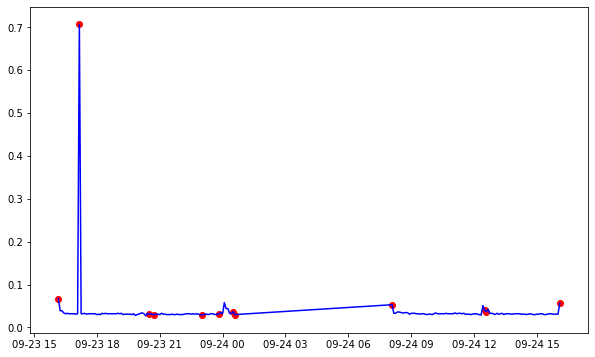

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
a = cics_df.loc[cics_df['anomaly3'] == -1, ['ENDSTAMP', 'MSRESPTIME']] #anomaly

ax.plot(cics_df['ENDSTAMP'], cics_df['MSRESPTIME'], color='blue')
ax.scatter(a['ENDSTAMP'],a['MSRESPTIME'], color='red')
plt.show();

/Users/kyu.kim@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/kyu.kim@ibm.com/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


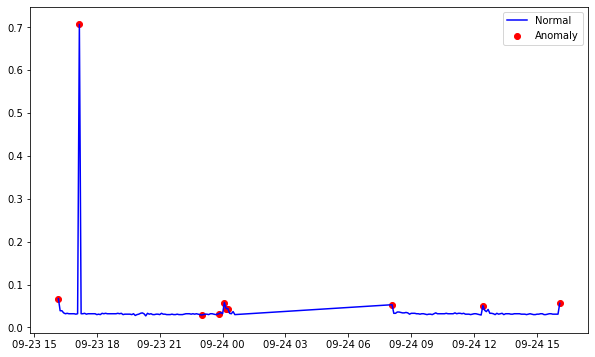

In [27]:
#Isolation Forest detects anomalies purely based on the fact 
#that anomalies are data points that are few and different. 
#The anomalies isolation is implemented without employing 
#any distance or density measure. This method is fundamentally 
#different from clustering based or distance based algorithms.

# we can try isolation forest
from sklearn.ensemble import IsolationForest

#Isolation Forest Application
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data) 
cics_df['anomaly2'] = pd.Series(model.predict(data)).to_list()

fig, ax = plt.subplots(figsize=(10,6))
a = cics_df.loc[cics_df['anomaly2'] == -1, ['ENDSTAMP', 'MSRESPTIME']] #anomaly
ax.plot(cics_df['ENDSTAMP'], cics_df['MSRESPTIME'], color='blue', label = 'Normal')
ax.scatter(a['ENDSTAMP'],a['MSRESPTIME'], color='red', label = 'Anomaly')
plt.legend()
plt.show();


